本コンペは日次の野菜卸売価格の予測タスクですが、ここでは簡単のため、月次の予測タスクに読み替えてみます（日毎に予測値は変えない）<br>
本notebookでは学習・推論を行います。前のnotebookで前処理を行った後、実行してください

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # コンペデータを格納しているパスを指定ください
PATH = '/content/drive/MyDrive/cpt-yasai-2023au'

In [3]:
%cd $PATH

[WinError 3] 指定されたパスが見つかりません。: '/content/drive/MyDrive/cpt-yasai-2023au'
C:\Users\s-heya\Desktop\nishika\生鮮野菜の価格予測2023秋\notebook


In [4]:
!pip install -q japanize-matplotlib

In [5]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic")
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [6]:
def root_mean_squared_percentage_error(true_y, pred_y):
    return np.sqrt(np.mean(((pred_y - true_y) / true_y)**2))*100

まずはデータの概要を把握します

In [7]:
CPT_DIR = Path("output")
INPUT_DIR = Path("data/input/")

In [9]:
train_df = pd.read_csv('../notebook/tutorial_preprocessed_train.csv')
print(train_df.shape)
train_df

(69104, 7)


,kind,date,amount,mode_price,area,year,weekno
0,かぶ,20051107,39319.0,158.0,千葉,2005,45
1,かぶ,20051108,35433.0,158.0,千葉,2005,45
2,かぶ,20051110,40208.0,126.0,千葉,2005,45
3,かぶ,20051111,32032.0,137.0,千葉,2005,45
4,かぶ,20051112,38288.0,137.0,千葉,2005,45
...,...,...,...,...,...,...,...
69099,しめじ,20170526,17231.0,48.5,新潟_長野,2017,21
69100,しめじ,20170527,17105.0,48.5,新潟_長野,2017,21
69101,しめじ,20170529,12406.0,48.5,新潟_長野,2017,22
69102,しめじ,20170530,12320.0,48.5,新潟_長野,2017,22


In [11]:
test_df = pd.read_csv('../notebook/tutorial_preprocessed_test.csv')
print(test_df.shape)
test_df

(220, 7)


,kind,date,amount,mode_price,area,year,weekno
0,にんじん,20230701,NaN,NaN,帯広_全国_青森,2023,26
1,にんじん,20230703,NaN,NaN,帯広_全国_青森,2023,27
2,にんじん,20230704,NaN,NaN,帯広_全国_青森,2023,27
3,にんじん,20230706,NaN,NaN,帯広_全国_青森,2023,27
4,にんじん,20230707,NaN,NaN,帯広_全国_青森,2023,27
...,...,...,...,...,...,...,...
215,じゃがいも,20230725,NaN,NaN,全国_水戸_浜松,2023,30
216,じゃがいも,20230727,NaN,NaN,全国_水戸_浜松,2023,30
217,じゃがいも,20230728,NaN,NaN,全国_水戸_浜松,2023,30
218,じゃがいも,20230729,NaN,NaN,全国_水戸_浜松,2023,30


この後月次で値を見ていくので、年・月のカラムを新たに作成しておきます

In [12]:
train_df['year'] = train_df['date']//10000
test_df['year'] = test_df['date']//10000
train_df['month'] = train_df['date'].apply(lambda x: int(str(x)[4:6]))
test_df['month'] = test_df['date'].apply(lambda x: int(str(x)[4:6]))

連続変数のカラムについて、基本統計量を確認します

In [13]:
train_df.describe()

,date,amount,mode_price,year,weekno,month
count,6.910400e+04,69104.000000,69104.000000,69104.000000,69104.000000,69104.000000
mean,2.014039e+07,83800.419136,1344.053383,2013.972447,26.697514,6.543644
std,5.057104e+04,88530.299942,1489.217123,5.059511,15.577581,3.576285
min,2.005111e+07,1.000000,18.500000,2005.000000,1.000000,1.000000
25%,2.010021e+07,18654.000000,167.500000,2010.000000,13.000000,3.000000
50%,2.014052e+07,48403.500000,1188.000000,2014.000000,25.000000,6.000000
75%,2.018101e+07,121612.500000,1836.000000,2018.000000,41.000000,10.000000
max,2.023063e+07,954540.000000,25920.000000,2023.000000,53.000000,12.000000


In [14]:
test_df.describe()

,date,amount,mode_price,year,weekno,month
count,2.200000e+02,0.0,0.0,220.0,220.00000,220.0
mean,2.023072e+07,NaN,NaN,2023.0,28.50000,7.0
std,8.942415e+00,NaN,NaN,0.0,1.30856,0.0
min,2.023070e+07,NaN,NaN,2023.0,26.00000,7.0
25%,2.023071e+07,NaN,NaN,2023.0,27.00000,7.0
50%,2.023072e+07,NaN,NaN,2023.0,28.50000,7.0
75%,2.023072e+07,NaN,NaN,2023.0,30.00000,7.0
max,2.023073e+07,NaN,NaN,2023.0,31.00000,7.0


trainデータの期間は2005年11月から2022年4月まで、testデータの期間は2022年の5月のみになっています

目的変数についてもう少し分析します。野菜種別ごとにどうなっているか確認します

In [15]:
TARGET = 'mode_price'

In [16]:
train_df.groupby('kind')[[TARGET]].mean().sort_values(by=TARGET, ascending=False)

,mode_price
kind,
まつたけ,12224.080560
うめ,4337.618622
たけのこ,3475.177711
さといも,3106.558135
ピース,2728.024752
セルリー,2591.718072
かぼちゃ,2450.150242
そらまめ,2169.238054
じゃがいも,2112.644089


野菜ごとに大きく価格は異なっています。<br>
従って、野菜種別は説明変数に入れるべき、ないし野菜ごとにモデルを作るべき、と考えます

train, testに入っている野菜種別を見てみます

In [17]:
train_df['kind'].unique(), test_df['kind'].unique()

(array(['かぶ', 'にんじん', 'ごぼう', 'れんこん', 'キャベツ', 'はくさい', 'こまつな', 'しゅんぎく',
        'ブロッコリー', 'きゅうり', 'かぼちゃ', 'トマト', 'ピーマン', 'じゃがいも', 'さつまいも', 'さといも',
        'なましいたけ', 'セルリー', 'さやえんどう', 'なのはな', 'たけのこ', 'ふき', 'うど', 'そらまめ',
        'アスパラガス', 'ピース', 'うめ', 'まつたけ', 'オクラ', 'みずな', 'にら', 'えのきだけ', 'しめじ'],
       dtype=object),
 array(['にんじん', 'キャベツ', 'はくさい', 'こまつな', 'ブロッコリー', 'きゅうり', 'かぼちゃ', 'トマト',
        'ピーマン', 'じゃがいも'], dtype=object))

In [18]:
len(train_df['kind'].unique()), len(test_df['kind'].unique())

(33, 10)

trainにしかない野菜種別が多く存在します。<br>
今回は野菜種別が重要な説明変数と考えるので、trainにしかない野菜種別は除いて学習することとします

In [19]:
kinds = test_df['kind'].unique()
train_df = train_df[train_df['kind'].isin(kinds)]
print(train_df.shape)
train_df

(42989, 8)


,kind,date,amount,mode_price,area,year,weekno,month
3325,にんじん,20051107,153402.0,892.5,帯広_千葉,2005,45,11
3326,にんじん,20051108,125763.0,1155.0,帯広_千葉,2005,45,11
3327,にんじん,20051110,114827.0,1050.0,帯広_千葉_全国,2005,45,11
3328,にんじん,20051111,100503.0,1050.0,帯広_千葉_全国,2005,45,11
3329,にんじん,20051112,109935.0,787.5,帯広_千葉,2005,45,11
...,...,...,...,...,...,...,...,...
50577,じゃがいも,20230624,96926.0,2376.0,全国_長崎_浜松,2023,25,6
50578,じゃがいも,20230626,120423.0,2376.0,全国_長崎_浜松,2023,26,6
50579,じゃがいも,20230627,66240.0,3240.0,全国_長崎_浜松,2023,26,6
50580,じゃがいも,20230629,120399.0,2376.0,全国_長崎_浜松,2023,26,6


データを見ると、必ずしも毎日レコードがあるわけではありません。レコードが存在する日数を種類別・月別にカウントしてみます

In [20]:
pd.pivot_table(train_df.query('20211101 <= date <= 20221031'), index='kind', columns='month', values=TARGET, aggfunc='count')

month,1,2,3,4,5,6,7,8,9,10,11,12
kind,,,,,,,,,,,,
かぼちゃ,NaN,NaN,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,20.0
きゅうり,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
こまつな,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,20.0
じゃがいも,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
にんじん,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
はくさい,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
キャベツ,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
トマト,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0
ピーマン,20.0,20.0,22.0,22.0,20.0,21.0,22.0,21.0,21.0,22.0,22.0,21.0


全ての野菜について、レコード数は月に20日強にとどまっています。<br>
つまり、取引が行われていない日があります。市場に野菜が出ていない可能性もありますが、全ての野菜について取引が行われていない場合、市場自体が空いていないと考えられます

卸売価格の推移をグラフに描画してみます

In [21]:
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

取引のない日のレコード分ダミーデータを作成して、綺麗に可視化されるようにします

In [22]:
all_df.drop('weekno', axis=1, inplace=True)

In [23]:
max_days = (datetime(2022, 12, 31) - datetime(2005, 1, 1)).days

dum_data = []

for i in range(max_days+1):
    date = datetime(2005, 1, 1) + timedelta(days=i)
    y, wn = date.isocalendar()[0], date.isocalendar()[1]
    date = int(date.strftime('%Y%m%d'))
    m = int(str(date)[4:6])
    dum_data.append(['ダミー', date, 0, 0, 'ダミー', y, m])

dum_df = pd.DataFrame(dum_data, columns=all_df.columns)
dum_df.head()

,kind,date,amount,mode_price,area,year,month
0,ダミー,20050101,0,0,ダミー,2004,1
1,ダミー,20050102,0,0,ダミー,2004,1
2,ダミー,20050103,0,0,ダミー,2005,1
3,ダミー,20050104,0,0,ダミー,2005,1
4,ダミー,20050105,0,0,ダミー,2005,1


In [24]:
vis_df = pd.concat([all_df, dum_df])
vis_df = vis_df.query('20161101 <= date <= 20221031').reset_index(drop=True)
vis_df = pd.pivot_table(vis_df, index='date', columns='kind', values='mode_price').reset_index()
vis_df.fillna(0, inplace=True)
vis_df.head()

kind,date,かぼちゃ,きゅうり,こまつな,じゃがいも,にんじん,はくさい,キャベツ,ダミー,トマト,ピーマン,ブロッコリー
0,20161101,2808.0,2430.0,135.0,2052.0,2808.0,1728.0,2592.0,0.0,2268.0,86.0,2106.0
1,20161102,2052.0,2484.0,178.5,2052.0,2808.0,1836.0,2592.0,0.0,2376.0,86.0,2106.0
2,20161103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20161104,2106.0,2592.0,205.5,2700.0,2916.0,2160.0,2592.0,0.0,2376.0,86.0,2160.0
4,20161105,1998.0,2538.0,200.0,2052.0,2700.0,2700.0,2592.0,0.0,2376.0,86.0,2268.0


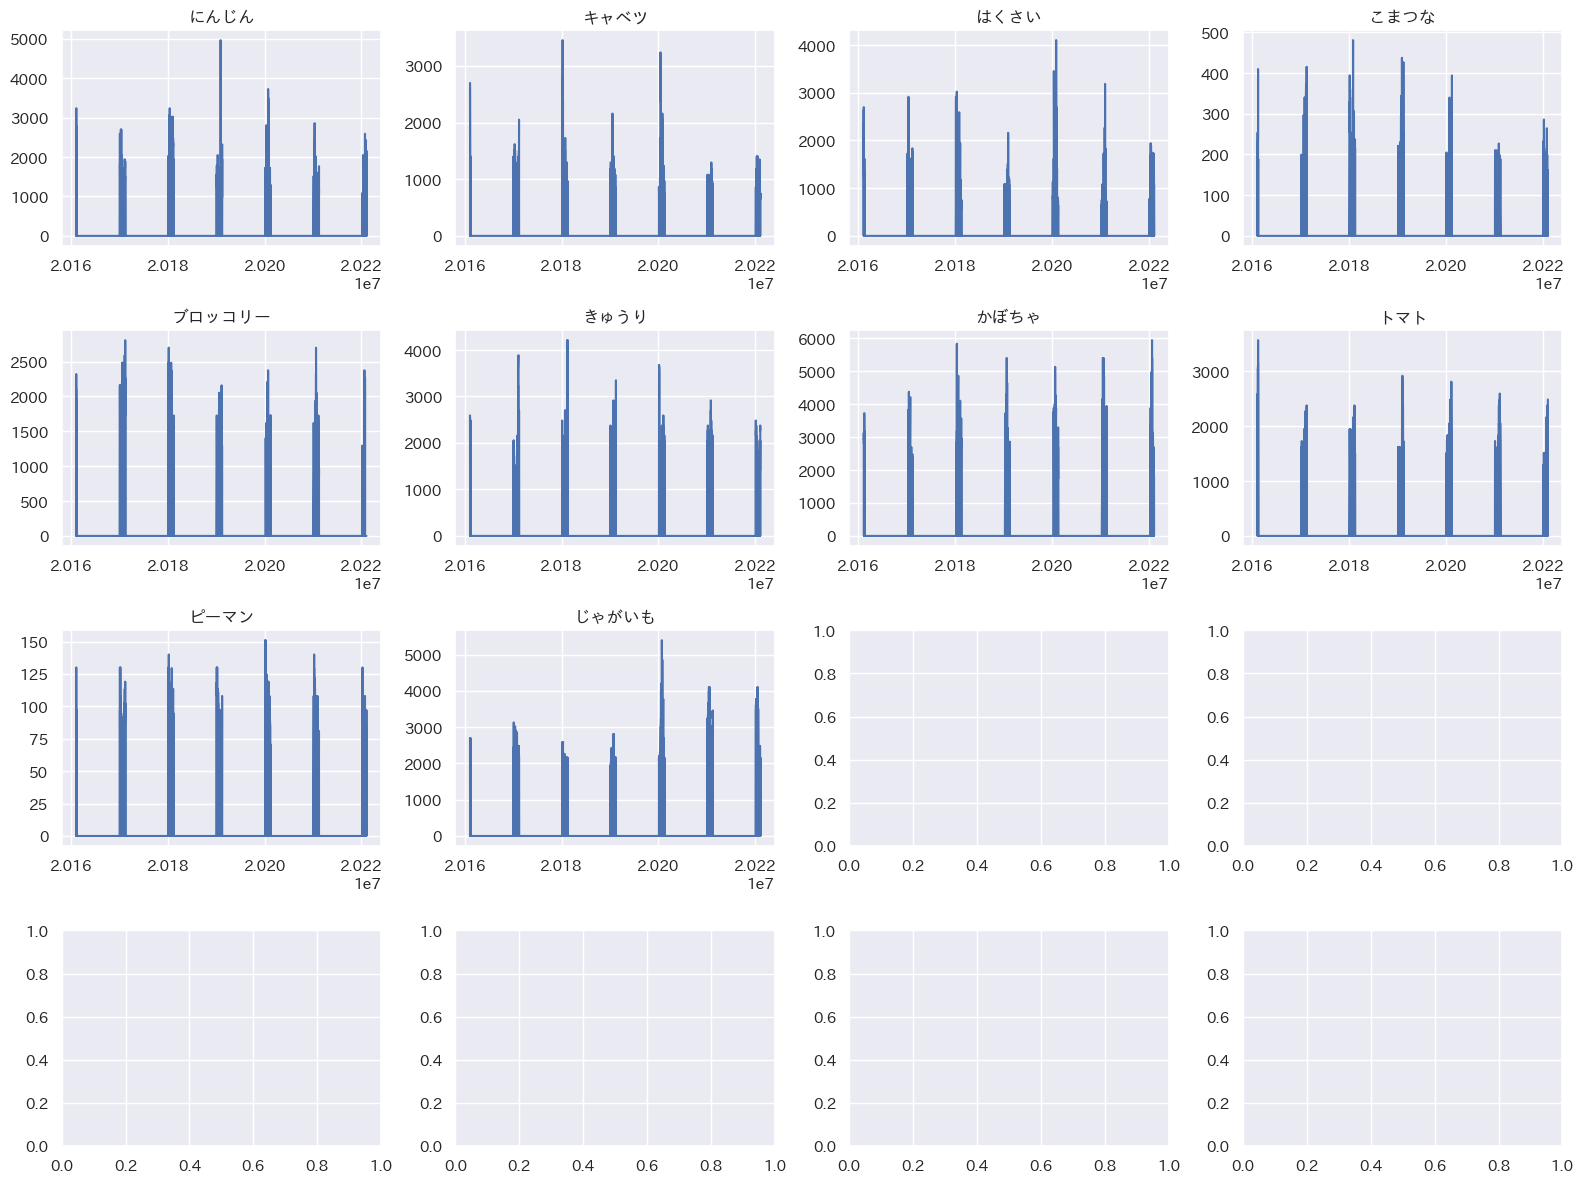

In [25]:
nrow = 4
ncol = 4

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 12))
for i, kind in enumerate(kinds):
    if i < nrow*ncol:
        df = vis_df.loc[:,['date',kind]]
        df.columns = ['date', TARGET]
        j = i//ncol
        k = i%ncol
        ax[j, k].plot(df['date'].to_list(), df[TARGET].to_list())
        ax[j, k].set_title(kind)
plt.tight_layout()
plt.show()
plt.close()

多くの野菜で年によって価格が大きく異なることがわかります。そのため：

- ある月の価格は、前年の価格より前月など直近の価格に近いものになっていると思われる
- 各年の価格の先行指標となる変数を探す必要がある

と言えそうです。<br>
価格の先行指標として、ここでは天候データを使ってみます。卸売価格データと結合します

In [26]:
have_data_combs = [list(i) for i in all_df[['kind','year','month']].drop_duplicates().values]
have_data_combs[:5]

dum_data = []

for kind in kinds:
    for year in range(2005, 2023):
        for month in range(1,13):
            if year < 2022 or (year == 2022 and month < 11):
                if [kind, year, month] not in have_data_combs:
                    date = year*10000+month*100+99
                    dum_data.append([kind,date,0,0,'全国',year, month])

dum_df = pd.DataFrame(dum_data, columns=all_df.columns)
dum_df.head()

,kind,date,amount,mode_price,area,year,month
0,にんじん,20050199,0,0,全国,2005,1
1,にんじん,20050299,0,0,全国,2005,2
2,にんじん,20050399,0,0,全国,2005,3
3,にんじん,20050499,0,0,全国,2005,4
4,にんじん,20050599,0,0,全国,2005,5


In [27]:
all_df = pd.concat([all_df, dum_df]).reset_index(drop=True)
all_df.head()

,kind,date,amount,mode_price,area,year,month
0,にんじん,20051107,153402.0,892.5,帯広_千葉,2005,11
1,にんじん,20051108,125763.0,1155.0,帯広_千葉,2005,11
2,にんじん,20051110,114827.0,1050.0,帯広_千葉_全国,2005,11
3,にんじん,20051111,100503.0,1050.0,帯広_千葉_全国,2005,11
4,にんじん,20051112,109935.0,787.5,帯広_千葉,2005,11


In [32]:
wea_df = pd.read_csv('../notebook/tutorial_preprocessed_weather.csv', encoding='cp932')
print(wea_df.shape)
wea_df

(44128, 21)


,year,month,mean_mean_temp,max_mean_temp,min_mean_temp,mean_max_temp,max_max_temp,min_max_temp,mean_min_temp,max_min_temp,...,mean_sum_rain,max_sum_rain,min_sum_rain,mean_sun_time,max_sun_time,min_sun_time,mean_mean_humid,max_mean_humid,min_mean_humid,area
0,2004.0,11.0,14.596000,19.300000,9.600000,18.340000,22.200000,12.400000,11.228000,17.400000,...,5.840000,87.000000,0.0,5.084000,9.500000,0.0,71.760000,93.000000,43.000000,千葉
1,2004.0,12.0,9.641935,19.000000,2.200000,13.564516,24.300000,3.800000,6.138710,11.500000,...,2.435484,26.000000,0.0,5.509677,9.400000,0.0,58.612903,86.000000,37.000000,千葉
2,2005.0,1.0,6.277419,13.100000,3.100000,10.461290,17.200000,5.200000,2.522581,6.400000,...,3.338710,66.500000,0.0,6.612903,9.800000,0.0,54.838710,89.000000,32.000000,千葉
3,2005.0,2.0,5.960714,12.000000,3.300000,9.864286,15.400000,5.100000,2.060714,4.600000,...,1.910714,11.500000,0.0,5.225000,9.700000,0.0,55.714286,93.000000,31.000000,千葉
4,2005.0,3.0,8.800000,13.700000,1.600000,13.122581,18.400000,3.600000,4.596774,10.000000,...,2.612903,22.500000,0.0,5.529032,11.300000,0.0,59.129032,91.000000,31.000000,千葉
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44123,2023.0,2.0,6.598958,12.529167,2.039583,10.959598,18.133333,4.456250,2.563095,7.968750,...,1.806176,23.010417,0.0,5.620015,10.741667,0.0,61.128720,87.583333,40.708333,全国_全国_横浜
44124,2023.0,3.0,12.152554,18.185417,6.779167,17.138306,23.993750,9.902083,7.724933,14.093750,...,3.669019,32.979167,0.0,6.117406,11.283333,0.0,67.059812,94.416667,46.125000,全国_全国_横浜
44125,2023.0,4.0,15.632431,20.166667,11.081250,20.583819,26.443750,15.029167,11.196736,16.668750,...,4.097569,40.885417,0.0,6.772986,12.577083,0.0,62.825000,91.145833,35.437500,全国_全国_横浜
44126,2023.0,5.0,18.817406,24.281250,13.441667,23.719019,30.958333,16.189583,14.647849,20.000000,...,6.129032,70.385417,0.0,6.778898,13.168750,0.0,70.098790,94.125000,43.291667,全国_全国_横浜


ラグ特徴量を作ります。以下では1,2,3,6,9,12ヶ月前の天候を特徴量としています

In [37]:
def add_weather_feat(all_df, nshift):

    mer_wea_df = wea_df.copy()
    mer_wea_df.columns = [f'{i}_{nshift}prev' if i not in ['year','month','area'] else i for i in mer_wea_df.columns]
    mer_wea_df = mer_wea_df.rename(columns={'year':'merge_year','month':'merge_month'})

    data = []

    for year, month in zip(all_df['year'].values, all_df['month'].values):
        month -= nshift
        if month <= 0:
            month += 12
            year -=1
        data.append([year, month])

    tmp_df = pd.DataFrame(data, columns=['merge_year','merge_month'])
    print(len(data),tmp_df.shape,all_df.shape, all_df.columns)

    mer_df = pd.concat([all_df, tmp_df],axis=1)

    mer_df = pd.merge(mer_df, mer_wea_df, on=['merge_year','merge_month','area'], how='left')
    mer_df.drop(['merge_year', 'merge_month'], axis=1, inplace=True)

    return mer_df


mer_df = all_df.copy()

for nshift in [1,2,3,6,9,12]:
    mer_df = add_weather_feat(mer_df, nshift)

print(mer_df.shape)
mer_df.head()

43452 (43452, 2) (43452, 7) Index(['kind', 'date', 'amount', 'mode_price', 'area', 'year', 'month'], dtype='object')
43452 (43452, 2) (43452, 25) Index(['kind', 'date', 'amount', 'mode_price', 'area', 'year', 'month',
       'mean_mean_temp_1prev', 'max_mean_temp_1prev', 'min_mean_temp_1prev',
       'mean_max_temp_1prev', 'max_max_temp_1prev', 'min_max_temp_1prev',
       'mean_min_temp_1prev', 'max_min_temp_1prev', 'min_min_temp_1prev',
       'mean_sum_rain_1prev', 'max_sum_rain_1prev', 'min_sum_rain_1prev',
       'mean_sun_time_1prev', 'max_sun_time_1prev', 'min_sun_time_1prev',
       'mean_mean_humid_1prev', 'max_mean_humid_1prev',
       'min_mean_humid_1prev'],
      dtype='object')
43452 (43452, 2) (43452, 43) Index(['kind', 'date', 'amount', 'mode_price', 'area', 'year', 'month',
       'mean_mean_temp_1prev', 'max_mean_temp_1prev', 'min_mean_temp_1prev',
       'mean_max_temp_1prev', 'max_max_temp_1prev', 'min_max_temp_1prev',
       'mean_min_temp_1prev', 'max_min_temp_1pr

,kind,date,amount,mode_price,area,year,month,mean_mean_temp_1prev,max_mean_temp_1prev,min_mean_temp_1prev,...,min_min_temp_12prev,mean_sum_rain_12prev,max_sum_rain_12prev,min_sum_rain_12prev,mean_sun_time_12prev,max_sun_time_12prev,min_sun_time_12prev,mean_mean_humid_12prev,max_mean_humid_12prev,min_mean_humid_12prev
0,にんじん,20051107,153402.0,892.5,帯広_千葉,2005,11,15.064516,20.05000,10.100000,...,-1.950000,3.230000,46.500000,0.0,5.386000,9.450000,0.0,68.940000,92.500000,43.50000
1,にんじん,20051108,125763.0,1155.0,帯広_千葉,2005,11,15.064516,20.05000,10.100000,...,-1.950000,3.230000,46.500000,0.0,5.386000,9.450000,0.0,68.940000,92.500000,43.50000
2,にんじん,20051110,114827.0,1050.0,帯広_千葉_全国,2005,11,16.176915,21.34375,11.026042,...,0.129167,3.305625,45.192708,0.0,5.406208,9.459375,0.0,68.585833,90.989583,45.53125
3,にんじん,20051111,100503.0,1050.0,帯広_千葉_全国,2005,11,16.176915,21.34375,11.026042,...,0.129167,3.305625,45.192708,0.0,5.406208,9.459375,0.0,68.585833,90.989583,45.53125
4,にんじん,20051112,109935.0,787.5,帯広_千葉,2005,11,15.064516,20.05000,10.100000,...,-1.950000,3.230000,46.500000,0.0,5.386000,9.450000,0.0,68.940000,92.500000,43.50000


In [ ]:
sys.exit()

目的変数と天候データ系変数の相関を確認します

In [38]:
agg_cols = [i for i in mer_df.columns if i not in ['kind','date','year','weekno','area','month','amount']]

for kind in mer_df.kind.unique():
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[agg_cols].mean()
    cor_df = gb_df.corr()
    print(kind)
    display(cor_df.query(f'0.5 <= {TARGET} < 1')[[TARGET]].sort_values(by=TARGET, ascending=False))

にんじん


,mode_price


キャベツ


,mode_price


はくさい


,mode_price


こまつな


,mode_price


ブロッコリー


,mode_price
mean_mean_humid_6prev,0.533317


きゅうり


,mode_price
max_sun_time_6prev,0.588664
min_min_temp_6prev,0.524594
min_mean_temp_6prev,0.513596
mean_min_temp_6prev,0.510365
mean_mean_temp_6prev,0.504961


かぼちゃ


,mode_price
min_mean_humid_9prev,0.652079
mean_mean_humid_9prev,0.616879
max_min_temp_12prev,0.573586
mean_min_temp_12prev,0.566912
mean_mean_temp_12prev,0.565637
max_mean_temp_12prev,0.555635
mean_max_temp_12prev,0.551237
min_max_temp_12prev,0.548743
min_min_temp_12prev,0.545249
min_mean_temp_12prev,0.544605


トマト


,mode_price
max_sun_time_6prev,0.514321
mean_mean_humid_3prev,0.510081


ピーマン


,mode_price
min_min_temp_6prev,0.587841
min_mean_humid_6prev,0.582561
min_mean_temp_6prev,0.579736
mean_min_temp_6prev,0.571279
min_max_temp_6prev,0.570688
mean_mean_humid_6prev,0.569405
mean_mean_temp_6prev,0.562015
mean_max_temp_6prev,0.552985
max_sun_time_9prev,0.543231
max_min_temp_6prev,0.536914


じゃがいも


,mode_price


野菜の種類によりますが、目的変数に対して相関係数0.5以上の天候データ系変数がある野菜もあり、一定の説明力が期待できます

予測モデルを構築します。<br>
LightGBMを使用します。比較のため、前月の値をそのまま予測値としたルールベースモデルも構築します

また、目的変数自身の1,2,3,6,9,12ヶ月前の値もラグ特徴量として取り入れます

In [39]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

In [42]:
# ルールベースの予測値

result = []

for kind in kinds:
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[TARGET].mean().reset_index()
    gb_df[f'{TARGET}_1prev'] = gb_df[TARGET].shift(1)
    #prev_value = gb_df.query('year==2022 & month==11')[f'{TARGET}_1prev'].values[0]
    prev_value = gb_df.query('year==2023 & month==7')[f'{TARGET}_1prev'].values[0]
    #result.append([kind,2022,11,prev_value])
    result.append([kind,2023,7,prev_value])

result_df = pd.DataFrame(result, columns=['kind','year','month',TARGET])

sub_df = pd.read_csv('../sample_submission.csv')
sub_df.drop(TARGET, axis=1, inplace=True)
sub_df['year'] = sub_df['date'].apply(lambda x: int(str(x)[:4]))
sub_df['month'] = sub_df['date'].apply(lambda x: int(str(x)[4:6]))
sub_df = pd.merge(sub_df, result_df, on=['kind','year','month'], how='left')
sub_df.drop(['year','month'], axis=1, inplace=True)

rule_sub_df = sub_df.copy()
rule_sub_df.columns = ['kind', 'date', f'rule_{TARGET}']
rule_sub_df.head()

,kind,date,rule_mode_price
0,にんじん,20230701,1467.818182
1,にんじん,20230703,1467.818182
2,にんじん,20230704,1467.818182
3,にんじん,20230706,1467.818182
4,にんじん,20230707,1467.818182


In [43]:
# モデルベースの予測値

result = []
model_dict = {}
pred_df_dict = {}
feature_imp_dict = {}
tra_df_dict = {}

for kind in kinds:

    print(kind)
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[agg_cols].mean().reset_index()
    gb_df[TARGET] = gb_df[TARGET].replace(0,np.nan)

    # 過去の値を特徴量とする
    for i in [1,2,3,6,9,12]:
        gb_df[f'{TARGET}_{i}prev'] = gb_df[TARGET].shift(i)

    #test_df = gb_df.query('year == 2022 & month == 11')
    test_df = gb_df.query('year == 2023 & month == 7')
    #train_df = gb_df.query('~(year == 2022 & month == 11)')
    train_df = gb_df.query('~(year == 2023 & month == 7)')
    train_df = train_df.query('year >= 2015') # 2015年以降のデータで学習
    train_df = train_df[train_df[TARGET].notnull()]

    cat_cols = []
    num_cols = [i for i in train_df.columns if i not in [TARGET, 'year', 'month', 'index', 'amount']]
    feat_cols = cat_cols + num_cols

    all_df = pd.concat([train_df, test_df])
    all_df[feat_cols] = all_df[feat_cols].fillna(method='bfill')
    all_df[feat_cols] = all_df[feat_cols].fillna(method='ffill')
    all_df[feat_cols] = all_df[feat_cols].fillna(0)
    train_df = all_df.iloc[:-1,:]
    test_df = all_df.iloc[-1:,:]

    # バリデーションはHold-out法（一定割合で学習データと評価データの2つに分割）で行う

    tra_df = train_df.iloc[:-1]
    val_df = train_df.iloc[-1:] # 2023年6月のデータでvalidation

    tra_x = tra_df[feat_cols]
    tra_y = tra_df[TARGET]
    val_x = val_df[feat_cols]
    val_y = val_df[TARGET]
    test_x = test_df[feat_cols]
    test_y = test_df[TARGET]

    tra_data = lgb.Dataset(tra_x, label=tra_y)
    val_data = lgb.Dataset(val_x, label=val_y)

    model = lgb.train(
        params,
        tra_data,
        categorical_feature = cat_cols,
        valid_names = ['train', 'valid'],
        valid_sets =[tra_data, val_data],
        #verbose_eval = 100,
    )

    val_pred = model.predict(val_x, num_iteration=model.best_iteration)

    pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), tra_x.columns)), columns=['importance', 'feature'])

    test_pred = model.predict(test_x, num_iteration=model.best_iteration)

    #result.append([kind,2022,11,test_pred[0]])
    result.append([kind,2023,7,test_pred[0]])
    model_dict[kind] = model
    pred_df_dict[kind] = pred_df
    feature_imp_dict[kind] = feature_imp
    tra_df_dict[kind] = tra_df

にんじん


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


キャベツ


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


はくさい


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


こまつな


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ブロッコリー


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


きゅうり


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


かぼちゃ


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


トマト


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ピーマン


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


じゃがいも


C:\Users\s-heya\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


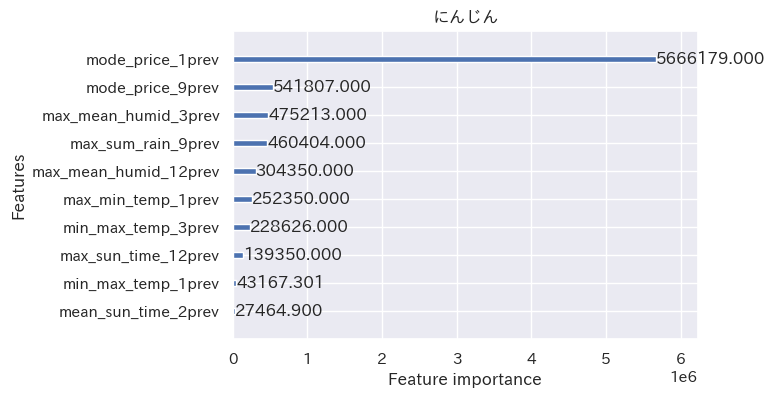

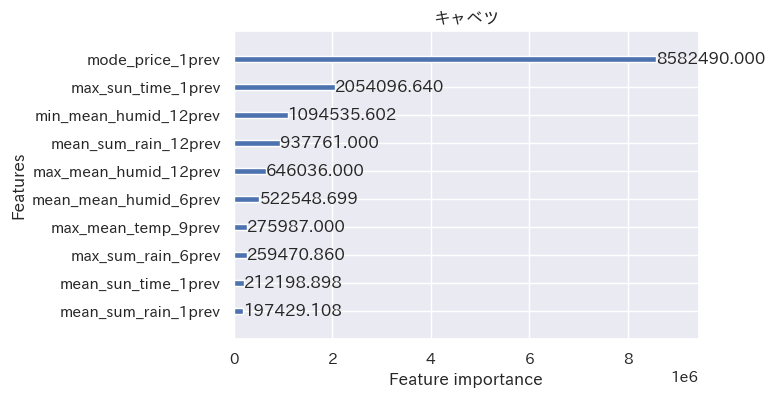

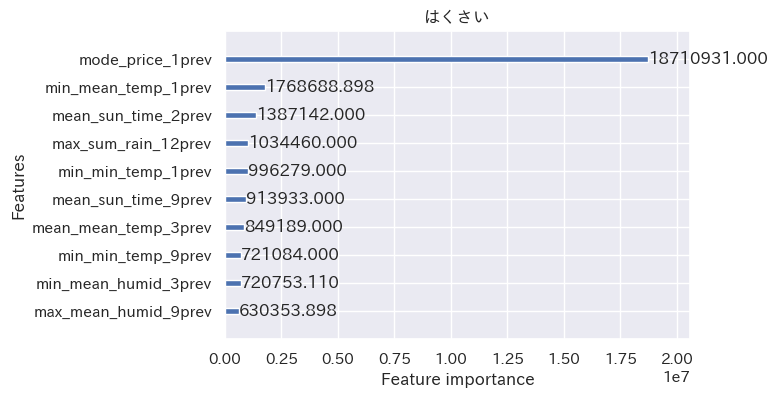

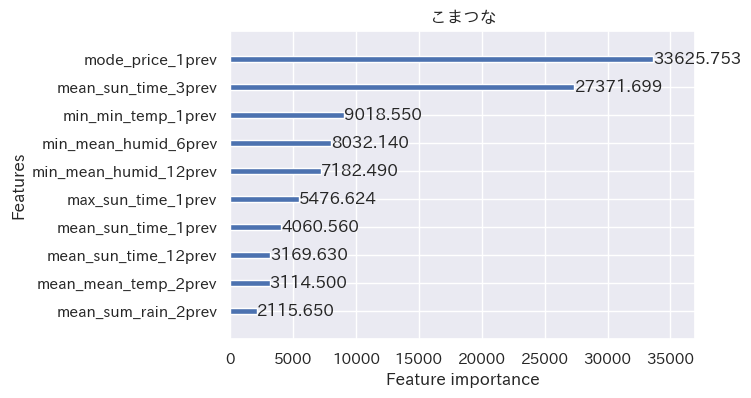

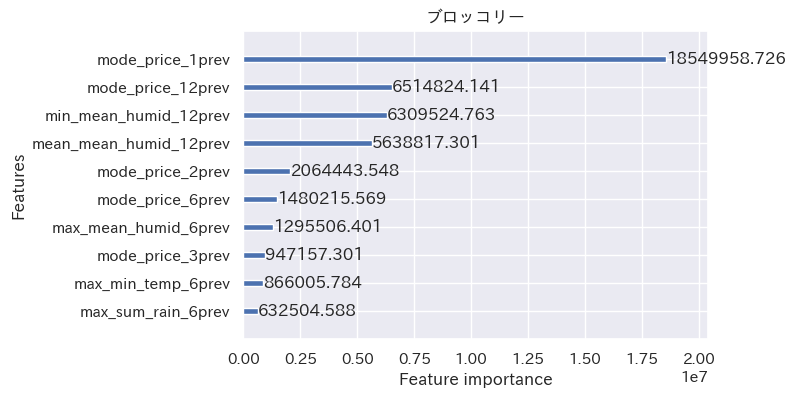

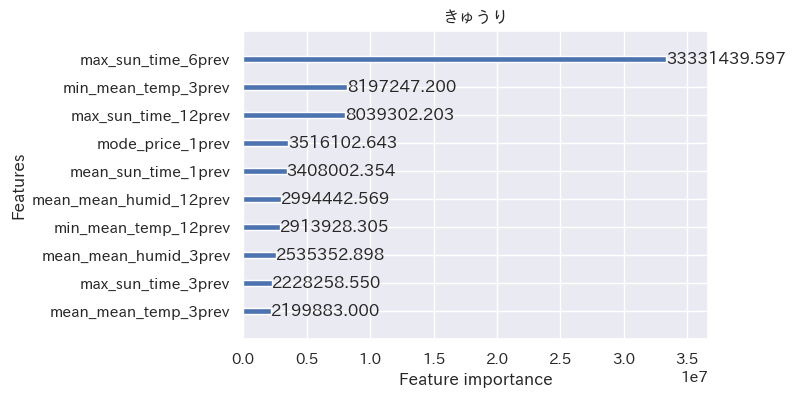

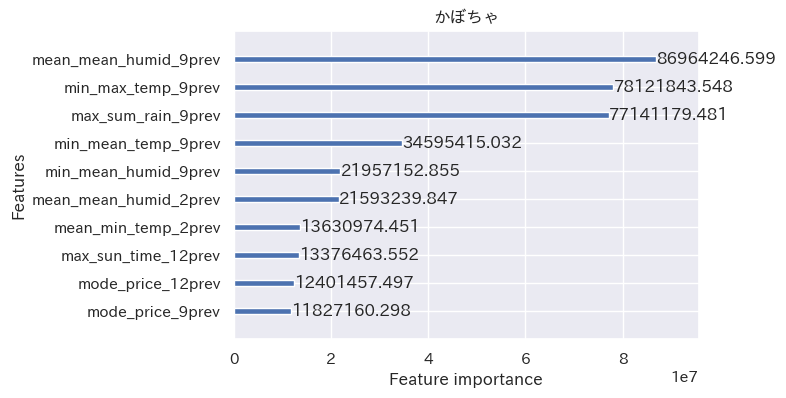

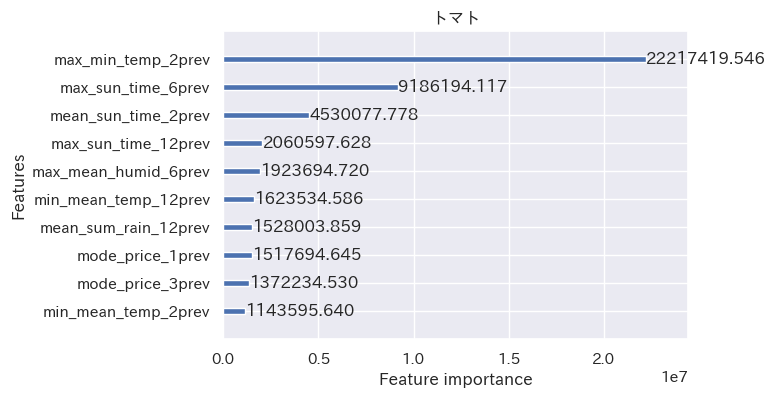

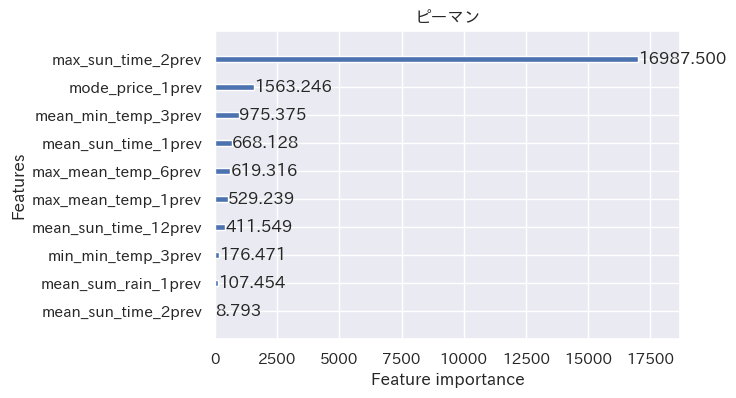

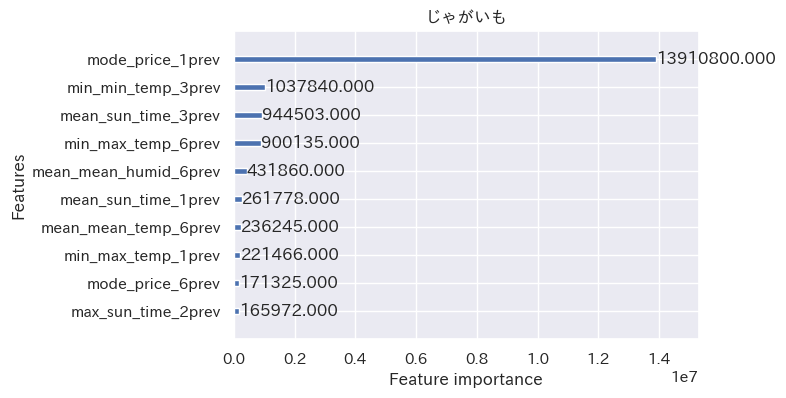

In [44]:
for kind in kinds:
    model = model_dict[kind]
    lgb.plot_importance(model, figsize=(6,4), max_num_features=10, importance_type='gain', title=kind)
plt.show()
plt.close()

In [57]:
for o in test_x:
    print(o)

mean_mean_temp_1prev
max_mean_temp_1prev
min_mean_temp_1prev
mean_max_temp_1prev
max_max_temp_1prev
min_max_temp_1prev
mean_min_temp_1prev
max_min_temp_1prev
min_min_temp_1prev
mean_sum_rain_1prev
max_sum_rain_1prev
min_sum_rain_1prev
mean_sun_time_1prev
max_sun_time_1prev
min_sun_time_1prev
mean_mean_humid_1prev
max_mean_humid_1prev
min_mean_humid_1prev
mean_mean_temp_2prev
max_mean_temp_2prev
min_mean_temp_2prev
mean_max_temp_2prev
max_max_temp_2prev
min_max_temp_2prev
mean_min_temp_2prev
max_min_temp_2prev
min_min_temp_2prev
mean_sum_rain_2prev
max_sum_rain_2prev
min_sum_rain_2prev
mean_sun_time_2prev
max_sun_time_2prev
min_sun_time_2prev
mean_mean_humid_2prev
max_mean_humid_2prev
min_mean_humid_2prev
mean_mean_temp_3prev
max_mean_temp_3prev
min_mean_temp_3prev
mean_max_temp_3prev
max_max_temp_3prev
min_max_temp_3prev
mean_min_temp_3prev
max_min_temp_3prev
min_min_temp_3prev
mean_sum_rain_3prev
max_sum_rain_3prev
min_sum_rain_3prev
mean_sun_time_3prev
max_sun_time_3prev
min_sun_time

submissionファイルを作成します

In [46]:
result_df = pd.DataFrame(result, columns=['kind','year','month',TARGET])

sub_df = pd.read_csv('../sample_submission.csv')
sub_df.drop(TARGET, axis=1, inplace=True)
sub_df['year'] = sub_df['date'].apply(lambda x: int(str(x)[:4]))
sub_df['month'] = sub_df['date'].apply(lambda x: int(str(x)[4:6]))
sub_df = pd.merge(sub_df, result_df, on=['kind','year','month'], how='left')
sub_df.drop(['year','month'], axis=1, inplace=True)
sub_df.columns = ['kind', 'date', f'model_{TARGET}']
sub_df.head()

,kind,date,model_mode_price
0,にんじん,20230701,1473.288703
1,にんじん,20230703,1473.288703
2,にんじん,20230704,1473.288703
3,にんじん,20230706,1473.288703
4,にんじん,20230707,1473.288703


validationデータを使って、評価値をルールベースとモデルベースで比較します

In [47]:
data = []

for kind in sub_df['kind'].unique():
    actual = pred_df_dict[kind]['actual'][0]
    model_pred = pred_df_dict[kind]['predict'][0]
    rule_pred = tra_df_dict[kind][[TARGET]].iat[-1,0]
    data.append([kind, 20230701, actual, model_pred, rule_pred])

score_df = pd.DataFrame(data, columns=['kind','date','mode_price','model_mode_price','rule_mode_price'])

def _calc_model_metric(row):
    return np.sqrt(np.mean(((row['model_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

def _calc_rule_metric(row):
    return np.sqrt(np.mean(((row['rule_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

score_df['pct_model'] = score_df.apply(_calc_model_metric, axis=1)
score_df['pct_rule'] = score_df.apply(_calc_rule_metric, axis=1)
score_df['pct_diff'] = score_df['pct_rule'] - score_df['pct_model']
score_df.drop_duplicates().sort_values('pct_diff', ascending=False)

,kind,date,mode_price,model_mode_price,rule_mode_price,pct_model,pct_rule,pct_diff
4,ブロッコリー,20230701,1961.181818,1608.418853,432.000,17.987265,77.972466,59.985201
0,にんじん,20230701,1467.818182,1526.674273,1838.700,4.009767,25.267559,21.257791
5,きゅうり,20230701,1453.090909,1455.744643,1166.400,0.182627,19.729730,19.547103
6,かぼちゃ,20230701,5031.818182,3569.774914,7438.500,29.055964,47.829268,18.773305
1,キャベツ,20230701,932.727273,927.814429,772.200,0.526718,17.210526,16.683808
2,はくさい,20230701,1046.863636,1135.289665,1301.400,8.446757,24.314185,15.867428
3,こまつな,20230701,155.295455,142.873951,121.150,7.998627,21.987414,13.988788
8,ピーマン,20230701,87.477273,83.166903,72.725,4.927417,16.864121,11.936704
7,トマト,20230701,1148.727273,1217.261669,1263.600,5.966116,10.000000,4.033884
9,じゃがいも,20230701,2557.636364,2423.250049,2438.100,5.254317,4.673704,-0.580612


In [48]:
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

In [49]:
rule_sub_df.rename(columns={'rule_mode_price':'mode_price'}).to_csv(OUTPUT_DIR/'rule_submission.csv', index=False)
sub_df.rename(columns={'model_mode_price':'mode_price'}).to_csv(OUTPUT_DIR/'test_tutorial_submission.csv', index=False)